# Feasibility Test 2 - Evaluation

[Model 2](readme.md) is a Random Intercept Cross-Lagged Panel Model (RI-CLPM) designed to examine how three skills – vocabulary, letter sound knowledge, and word reading – develop over time and how they influence each other using repeated test scores at four time points.

The model is defined in [model.py](model.py).

Here, we test the model using observed variables from data set 1 times 1 through 4.

## Preliminaries


In [1]:
import platform
import os
import sys
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import pytensor
import pytensor.tensor as pt
import model as m
from model import ModelConfig, ModelSpecification
import xarray as xr

pd.options.mode.copy_on_write = True

pytensor.config.mode = "NUMBA"
pytensor.config.print_active_device = True

az.style.use("arviz-whitegrid")

environment = {
    "platform": platform.platform(),
    "platform_version": platform.version(),
    "architecture": platform.architecture(),
    "processor": platform.processor(),
    "cpu_count": os.cpu_count(),
    "python": sys.version,
    "pymc": pm.__version__,
    "pytensor": pytensor.__version__,
    "numpy": np.__version__,
    "arviz": az.__version__,
}

print("Environment:")
for key, value in environment.items():
    print(f"  {key}: {value}")

Environment:
  platform: Windows-11-10.0.26120-SP0
  platform_version: 10.0.26120
  architecture: ('64bit', 'WindowsPE')
  processor: Intel64 Family 6 Model 183 Stepping 1, GenuineIntel
  cpu_count: 32
  python: 3.13.7 (tags/v3.13.7:bcee1c3, Aug 14 2025, 14:15:11) [MSC v.1944 64 bit (AMD64)]
  pymc: 5.25.1
  pytensor: 2.31.7
  numpy: 2.3.3
  arviz: 0.22.0


### Load data


In [2]:
df = pd.read_csv(
    "../../../../../data/reading-language-intervention-trial/rli-trial-data.csv"
).convert_dtypes()
df = df[df["included"] == 1]

## Evaluate model


### Build model


In [3]:
spec = ModelSpecification(
    age=df["age_t1"].to_numpy(na_value=np.nan),
    gender=df["gender"].to_numpy(na_value=np.nan),
    area=df["area"].to_numpy(na_value=np.nan),
    rv=df[
        ["recep_vocab_t1", "recep_vocab_t2", "recep_vocab_t3", "recep_vocab_t4"]
    ].to_numpy(na_value=np.nan),
    ls=df[
        ["letter_sound_t1", "letter_sound_t2", "letter_sound_t3", "letter_sound_t4"]
    ].to_numpy(na_value=np.nan),
    wr=df[
        ["word_reading_t1", "word_reading_t2", "word_reading_t3", "word_reading_t4"]
    ].to_numpy(na_value=np.nan),
)

model = m.build_model(spec)

### Model graph


In [4]:
# pm.model_to_graphviz(model)

### Run simulation


In [5]:
CHAINS = 6
CORES = CHAINS
RANDOM_SEED = 202509
rng = np.random.default_rng(RANDOM_SEED)

posterior_keep = [
    "B",
    "B_autoregressive",
    "B_crosslag",
    "B_half_life",
    "mu",
    "beta_age",
    "beta_person",
    "rho",
    "alpha_sd",
    "alpha_corr",
    "eta_sd",
    "delta",
    "p_bar",
    "items_per_logit",
]

with model:
    idata = pm.sample(
        draws=8000,
        tune=4000,
        chains=CHAINS,
        cores=CORES,
        target_accept=0.96,
        var_names=posterior_keep,
        idata_kwargs={"log_likelihood": True},
        return_inferencedata=True,
        init="jitter+adapt_diag",
        nuts_sampler="numpyro",
        chain_method="vectorized",
        # compile_kwargs=dict(mode="NUMBA"),
        random_seed=RANDOM_SEED,
    )

v:\dev\dseinternational\development-models\.venv\Lib\site-packages\pytensor\link\c\cmodule.py:2968: UserWarning: PyTensor could not link to a BLAS installation. Operations that might benefit from BLAS will be severely degraded.
This usually happens when PyTensor is installed via pip. We recommend it be installed via conda/mamba/pixi instead.
Alternatively, you can use an experimental backend such as Numba or JAX that perform their own BLAS optimizations, by setting `pytensor.config.mode == 'NUMBA'` or passing `mode='NUMBA'` when compiling a PyTensor function.
For more options and details see https://pytensor.readthedocs.io/en/latest/troubleshooting.html#how-do-i-configure-test-my-blas-library
  warnings.warn(


  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

  0%|          | 0/12000 [00:00<?, ?it/s]

v:\dev\dseinternational\development-models\.venv\Lib\site-packages\jax\_src\interpreters\mlir.py:1316: UserWarning: Some donated buffers were not usable: float64[6,8000,6], float64[6,8000,54,3], float64[6,8000,54,3,3], float64[6,8000,6], float64[6,8000,54,3], float64[6,8000], float64[6,8000], float64[6,8000,54,4], float64[6,8000].
See an explanation at https://docs.jax.dev/en/latest/faq.html#buffer-donation.
  warnings.warn("Some donated buffers were not usable:"
There was 1 divergence after tuning. Increase `target_accept` or reparameterize.


## Diagnostics


In [6]:
az.bfmi(idata)

array([0.86992586, 0.83941991, 0.81503055, 0.83542524, 0.80498318,
       0.83722307])

<Axes: >

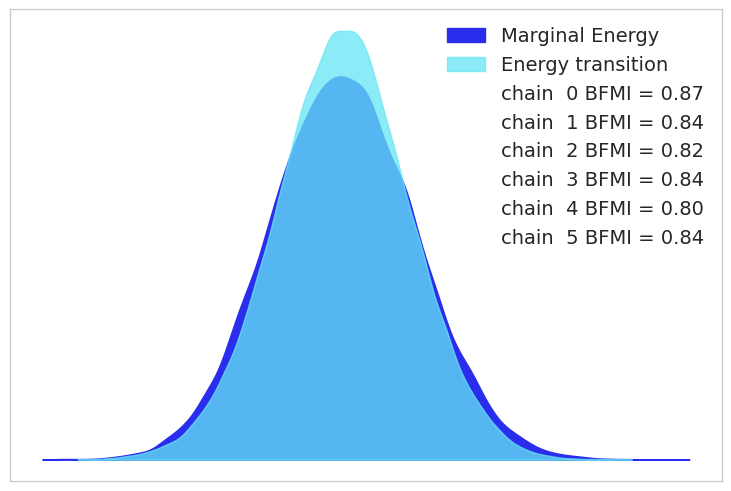

In [7]:
az.plot_energy(idata)

In [8]:
from pytensor import config

if config.mode.upper() == "NUMBA":
    config.mode = "FAST_COMPILE"

with model:
    # Prior predictive (force non-Numba mode)
    idata_pp = pm.sample_prior_predictive(
        samples=1000,
        var_names=[
            "mu",
            "B",
            "rho",
            "kappa",
            "alpha_sd",
            "alpha_corr",
            "eta_sd",
            "delta",
            "y",
        ],
        compile_kwargs={
            "mode": "FAST_COMPILE"
        }
    )
    idata.extend(idata_pp)

C:\Users\FrankBuckley\AppData\Local\Temp\ipykernel_49876\1443674258.py:8: UserWarning: The effect of Potentials on other parameters is ignored during prior predictive sampling. This is likely to lead to invalid or biased predictive samples.
  idata_pp = pm.sample_prior_predictive(
Sampling: [alpha_scale, alpha_z, beta_age, beta_person, day_raw, delta, delta_sd, eta_sd, init_scale, kappa_uncon, mu0, mu_step_sd, mu_steps, nu_mu_minus2, raw_B, state_shock, x1_z, y]


In [9]:

# 1) Get mu from the *prior* group (not prior_predictive)
mu = idata_pp.prior["mu"]                   # dims: ("chain","draw","construct","time")

# 2) Collapse chains -> one sample axis
mu_s = mu.stack(sample=("chain","draw"))    # dims: ("sample","construct","time")

# 3) Convert to probabilities
p = 1 / (1 + np.exp(-mu_s))                 # same dims

# 4) Quantiles over samples -> dims ("quantile","construct","time")
q = p.quantile(q=[0.05, 0.50, 0.95], dim="sample")

# 5a) Stay in xarray (recommended)
print(q)

# 5b) Or make a tidy pandas table with MultiIndex rows and quantiles as columns
df_p = (
    q.to_dataframe(name="p")                # index: quantile, construct, time
      .reset_index()
      .pivot_table(index=["construct","time"], columns="quantile", values="p")
      .rename(columns={0.05:"q05", 0.50:"q50", 0.95:"q95"})
      .sort_index()
)
df_p


<xarray.DataArray 'mu' (quantile: 3, construct: 3, time: 4)> Size: 288B
array([[[0.099756  , 0.08576126, 0.08189101, 0.07178285],
        [0.26509733, 0.23494752, 0.2164743 , 0.19442906],
        [0.03675411, 0.03150821, 0.02712417, 0.02455017]],

       [[0.19721608, 0.20037894, 0.20067988, 0.20460286],
        [0.44290713, 0.44501919, 0.44035261, 0.44697176],
        [0.0826521 , 0.08239018, 0.08220509, 0.08203628]],

       [[0.35981033, 0.40714008, 0.43090673, 0.45072355],
        [0.64037047, 0.68024449, 0.70708127, 0.71983963],
        [0.17104176, 0.19519003, 0.22937052, 0.24872791]]])
Coordinates:
  * construct  (construct) <U11 132B 'Vocab' 'LetterSound' 'WordReading'
  * time       (time) int64 32B 1 2 3 4
  * quantile   (quantile) float64 24B 0.05 0.5 0.95


quantile               q05       q50       q95
construct   time                              
LetterSound 1     0.265097  0.442907  0.640370
            2     0.234948  0.445019  0.680244
            3     0.216474  0.440353  0.707081
            4     0.194429  0.446972  0.719840
Vocab       1     0.099756  0.197216  0.359810
            2     0.085761  0.200379  0.407140
            3     0.081891  0.200680  0.430907
            4     0.071783  0.204603  0.450724
WordReading 1     0.036754  0.082652  0.171042
            2     0.031508  0.082390  0.195190
            3     0.027124  0.082205  0.229371
            4     0.024550  0.082036  0.248728

## Summaries


In [11]:
vars_to_report = [
    "B",
    "B_autoregressive",
    "B_crosslag",
    "B_half_life",
    "beta_age",
    "beta_person",
    "alpha_sd",
    "alpha_corr",
    "eta_sd",
    "mu",
    "p_bar",
    "items_per_logit",
    "delta",
]

summary = az.summary(idata, var_names=vars_to_report, hdi_prob=0.95)
summary.to_csv("summary.csv")
summary

v:\dev\dseinternational\development-models\.venv\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
v:\dev\dseinternational\development-models\.venv\Lib\site-packages\arviz\stats\diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
v:\dev\dseinternational\development-models\.venv\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered in scalar divide
  (between_chain_variance / within_chain_variance + num_samples - 1) / (num_samples)
v:\dev\dseinternational\development-models\.venv\Lib\site-packages\arviz\stats\diagnostics.py:991: RuntimeWarning: invalid value encountered in scalar divide
  varsd = varvar / evar / 4
v:\dev\dseinternational\development-models\.venv\Lib\site-packages\arviz\stats\diagnostics.py:596: RuntimeWarning: invalid value encountered i

,mean,sd,hdi_2.5%,hdi_97.5%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
"B[Vocab, Vocab]",0.108,0.186,-0.260,0.464,0.001,0.001,46780.0,35214.0,1.0
"B[Vocab, LetterSound]",-0.009,0.066,-0.140,0.120,0.000,0.000,20209.0,21445.0,1.0
"B[Vocab, WordReading]",0.025,0.098,-0.165,0.220,0.001,0.000,16929.0,28540.0,1.0
"B[LetterSound, Vocab]",-0.005,0.146,-0.287,0.280,0.001,0.001,58030.0,37812.0,1.0
"B[LetterSound, LetterSound]",0.236,0.118,-0.000,0.464,0.001,0.001,15098.0,21631.0,1.0
...,...,...,...,...,...,...,...,...,...
"items_per_logit[WordReading, 3]",8.166,1.047,6.152,10.227,0.009,0.005,14546.0,24594.0,1.0
"items_per_logit[WordReading, 4]",9.805,1.155,7.652,12.174,0.009,0.005,15027.0,25957.0,1.0
delta[Vocab],0.020,0.018,0.000,0.057,0.000,0.000,11071.0,14958.0,1.0
delta[LetterSound],0.085,0.114,0.000,0.350,0.003,0.004,1721.0,1686.0,1.0
